## Setup ##

In [1]:
!pip install tifffile 
!pip install scikit-image

nbformat 4.4.0 has requirement jsonschema!=2.5.0,>=2.4, but you'll have jsonschema 2.3.0 which is incompatible.
google-api-core 0.1.4 has requirement setuptools>=34.0.0, but you'll have setuptools 20.7.0 which is incompatible.
nbconvert 5.3.1 has requirement pandocfilters>=1.4.1, but you'll have pandocfilters 1.2 which is incompatible.
You are using pip version 10.0.0, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
google-api-core 0.1.4 has requirement setuptools>=34.0.0, but you'll have setuptools 20.7.0 which is incompatible.
nbconvert 5.3.1 has requirement pandocfilters>=1.4.1, but you'll have pandocfilters 1.2 which is incompatible.
nbformat 4.4.0 has requirement jsonschema!=2.5.0,>=2.4, but you'll have jsonschema 2.3.0 which is incompatible.
You are using pip version 10.0.0, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
# imports 
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F 
import torch.optim as optim

import numpy as np 
from skimage import measure
from skimage.transform import resize
import tifffile 

import aug
from os.path import join, expanduser

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
matplotlib.rcParams['axes.grid'] = False

from cloudvolume import CloudVolume
from cloudvolume.lib import Bbox, Vec
import numpy as np

In [2]:
data_dir = '../../../'
positive_images = tifffile.imread(join(data_dir, 'image.tif')).astype(np.float32)
positive_images = positive_images - np.mean(positive_images, axis=(1,2)).reshape((-1,1,1)) # normalize inputs
positive_images = positive_images / (np.std(positive_images, axis=(1,2)).reshape((-1,1,1)) + 1e-6)

In [9]:
image_cv_path = 'gs://neuroglancer/basil_v0/father_of_alignment/v3'
image_cv = CloudVolume(image_cv_path, mip=5, bounded=False, fill_missing=True, parallel=1, progress=False)
origin = Vec([131982, 99399, 180])
chunk_size = Vec([4096, 4096, 1])
bbox = Bbox(origin, origin+chunk_size)

In [10]:
pos_idx = 110 
neg_idx = 60

In [11]:
images_trn = np.concatenate((positive_images[pos_perm[:pos_idx]], negative_images[neg_perm[:neg_idx]]))
images_val = np.concatenate((positive_images[pos_perm[pos_idx:]], negative_images[neg_perm[neg_idx:]]))
print(images_trn.shape, images_val.shape)

(170, 1024, 1024) (64, 1024, 1024)


In [12]:
original_ids = np.array([1,2,3,4,5])
positive_labels = tifffile.imread(join(data_dir, 'label.tif'))
positive_labels = np.concatenate([np.expand_dims(positive_labels, 1) == i for i in original_ids], axis=1)
folds = (positive_labels[:,0,:,:] + positive_labels[:,1,:,:]) > 0
cracks = (positive_labels[:,2,:,:] + positive_labels[:,3,:,:] + positive_labels[:,4,:,:]) > 0
positive_labels = np.concatenate([np.expand_dims(folds,1), np.expand_dims(cracks,1)], axis=1)
positive_labels = positive_labels.astype(np.float32)
label_ids = np.array([1,2])
negative_labels = np.zeros((negative_images.shape[0], len(label_ids), *negative_images.shape[1:]))
negative_labels = negative_labels.astype(np.float32)
labels_trn = np.concatenate((positive_labels[pos_perm[:pos_idx]], negative_labels[neg_perm[:neg_idx]]))
labels_val = np.concatenate((positive_labels[pos_perm[pos_idx:]], negative_labels[neg_perm[neg_idx:]]))

print(labels_trn.shape, labels_val.shape)

(170, 2, 1024, 1024) (64, 2, 1024, 1024)


In [13]:
positive_labels.shape

(151, 2, 1024, 1024)

In [14]:
positive_images, negative_images = 0, 0
positive_labels, negative_labels = 0, 0

In [42]:
k = 8
mip2_size = images_trn[k].shape
mip5_img_size = np.array(mip2_size) // 2**3
mip5_label_size = np.concatenate(([len(label_ids)], mip5_img_size))

## Visualize Data ##

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


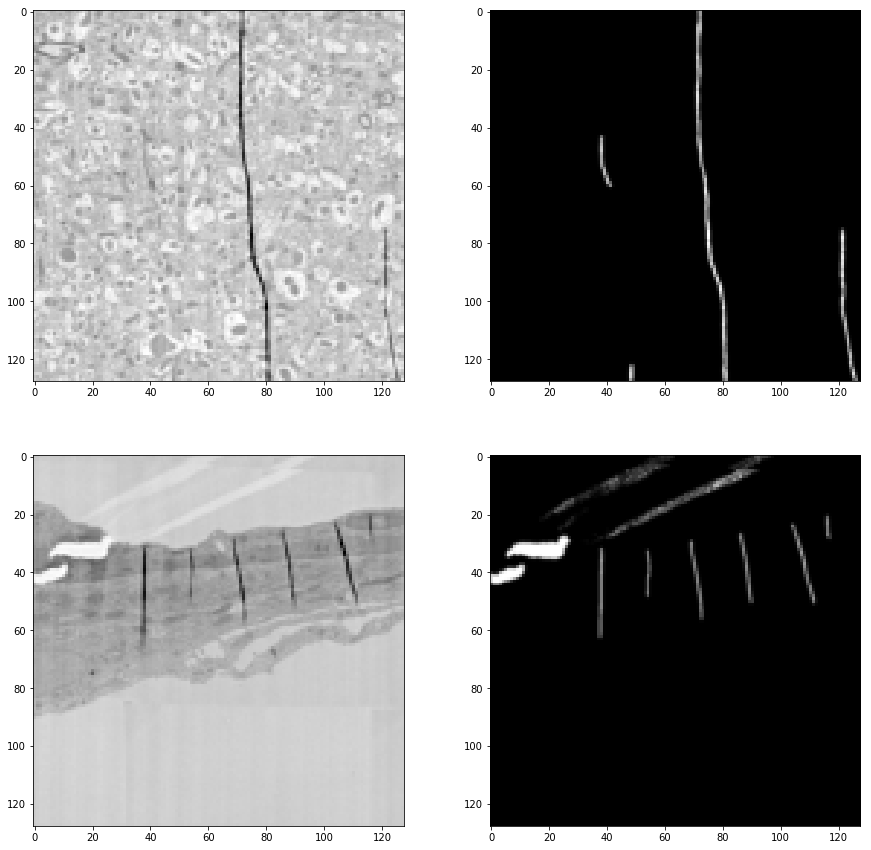

In [45]:
#@title Default title text
# visualize data
k = 8
plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(resize(images_trn[k], mip5_size, preserve_range=True, anti_aliasing=True), cmap='gray')
plt.subplot(222)
plt.imshow(resize(np.sum(labels_trn[k], axis=0), mip5_size, preserve_range=True, anti_aliasing=True), cmap='gray')
plt.grid(False)
plt.subplot(223)
plt.imshow(resize(images_val[k], mip5_size, preserve_range=True, anti_aliasing=True), cmap='gray')
plt.subplot(224)
plt.imshow(resize(np.sum(labels_val[k], axis=0), mip5_size, preserve_range=True, anti_aliasing=True), cmap='gray')
plt.grid(False)
plt.show()

In [26]:
# train utils
def np2var(arr, cuda):
    while len(arr.shape) < 4:
        arr = np.expand_dims(arr, 0)
    arr = torch.from_numpy(arr)
    arr = Variable(arr)
    if cuda:
        arr = arr.cuda()
    return arr

def var2np(arr):
    arr = arr.data.cpu().numpy()
    while len(arr.shape) > 2:
        arr = arr[0]
    return arr

## Create UNet ##

In [27]:
# helper operations 
def conv3x3(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels,
        kernel_size=3, stride=1, padding=1, bias=True)

def maxpool2x2():
    return nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

class UpConv2x2(nn.Module):
    def __init__(self, channels):
        super(UpConv2x2, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv = nn.Conv2d(channels, channels // 2,
            kernel_size=2, stride=1, padding=0, bias=True)

    def forward(self, x):
        x = self.upsample(x)
        x = F.pad(x, (0,1,0,1))
        x = self.conv(x)
        return x 
        
def concat(xh, xv):
    return torch.cat([xh, xv], dim=1)


# unet blocks
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels: number of channels in input (1st) feature map
            out_channels: number of channels in output feature maps
        """
        super(ConvBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.conv3 = conv3x3(out_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x

class DownConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels: number of channels in input (1st) feature map
            out_channels: number of channels in output feature maps
        """
        super(DownConvBlock, self).__init__()
        self.maxpool = maxpool2x2()
        self.conv1 = conv3x3(in_channels, out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.conv3 = conv3x3(out_channels, out_channels)

    def forward(self, x):
        x = self.maxpool(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x

class UpConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        """
        Args:
            in_channels: number of channels in input (1st) feature map
            out_channels: number of channels in output feature maps
        """
        super(UpConvBlock, self).__init__()
        self.upconv = UpConv2x2(in_channels)
        self.conv1 = conv3x3(in_channels, out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.conv3 = conv3x3(out_channels, out_channels)

    def forward(self, xh, xv):
        """
        Args:
            xh: torch Variable, activations from same resolution feature maps (gray arrow in diagram)
            xv: torch Variable, activations from lower resolution feature maps (green arrow in diagram)
        """
        xv = self.upconv(xv)
        x = concat(xh, xv)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        fs = [16,32,64,128,256]
        self.conv_in = ConvBlock(1, fs[0])
        self.dconv1 = DownConvBlock(fs[0], fs[1])
        self.dconv2 = DownConvBlock(fs[1], fs[2])
        self.dconv3 = DownConvBlock(fs[2], fs[3])
        self.dconv4 = DownConvBlock(fs[3], fs[4])

        self.uconv1 = UpConvBlock(fs[4], fs[3])
        self.uconv2 = UpConvBlock(fs[3], fs[2])
        self.uconv3 = UpConvBlock(fs[2], fs[1])
        self.uconv4 = UpConvBlock(fs[1], fs[0])
        self.conv_out = conv3x3(fs[0], len(label_ids))

        self._initialize_weights()

    def forward(self, x):
        x1 = self.conv_in(x)
        x2 = self.dconv1(x1)
        x3 = self.dconv2(x2)
        x4 = self.dconv3(x3)
        x5 = self.dconv4(x4)
        x6 = self.uconv1(x4, x5)
        x7 = self.uconv2(x3, x6)
        x8 = self.uconv3(x2, x7)
        x9 = self.uconv4(x1, x8)
        x10 = self.conv_out(x9)
        return x10

    def _initialize_weights(self):
        conv_modules = [m for m in self.modules() if isinstance(m, nn.Conv2d)]
        for m in conv_modules:
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, np.sqrt(2. / n))


## Train UNet ##

In [28]:
# plot utils
def plot_learning(plot_handles, ylabel):
    plt.legend(handles=plot_handles, loc="center right")
    plt.xlabel("Iterations")
    plt.ylabel(ylabel)
    
def plot(step, log_every, train_loss, val_loss, img_trn, img_val, label_trn, label_val, pred_trn, pred_val):
    clear_output(wait=False)
    plt.gcf().clear()
    
    x = 5
    y = 1 + len(label_ids)
    
    ax = plt.subplot(x,y,1)
    iters = np.arange(0,len(train_loss))*log_every
    train_plot, = plt.plot(iters, train_loss, 'r', label="training")
    val_plot, = plt.plot(iters, val_loss, 'b', label="validation")
    plot_learning([train_plot, val_plot], "Loss")
    plt.title("Cross entropy loss")
    ax.set_yscale("log")

    plt.subplot(x,y,y+1)
    plt.imshow(var2np(img_trn), cmap='gray')
    plt.title("Image, train")
    
    for k in range(len(label_ids)):
        plt.subplot(x,y,y+k+2)
        plt.imshow(var2np(F.sigmoid(pred_trn[k])), cmap='gray')
        plt.title("Pred {0}, train".format(label_ids[k]))
        
        plt.subplot(x,y,2*y+k+2)
        plt.imshow(var2np(label_trn[k]), cmap='gray')
        plt.title("Label {0}, train".format(label_ids[k]))
    
    plt.subplot(x,y,3*y+1)
    plt.imshow(var2np(img_val), cmap='gray')
    plt.title("Image, val")
    
    for k in range(len(label_ids)):
        plt.subplot(x,y,3*y+k+2)
        plt.imshow(var2np(F.sigmoid(pred_val[k])), cmap='gray')
        plt.title("Pred {0}, val".format(label_ids[k]))
        
        plt.subplot(x,y,4*y+k+2)
        plt.imshow(var2np(label_val[k]), cmap='gray')
        plt.title("Label {0}, val".format(label_ids[k]))


    plt.gcf().set_size_inches(18, 18)
    display(plt.gcf())

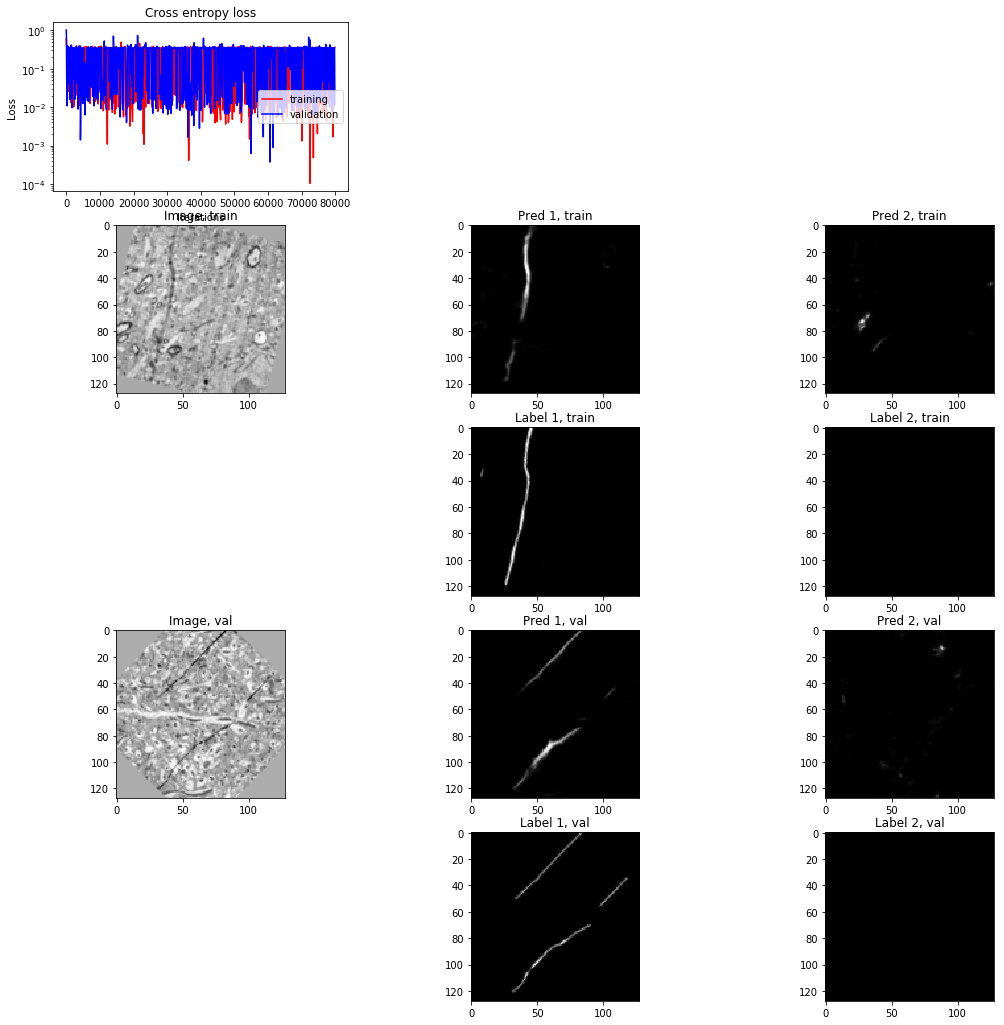

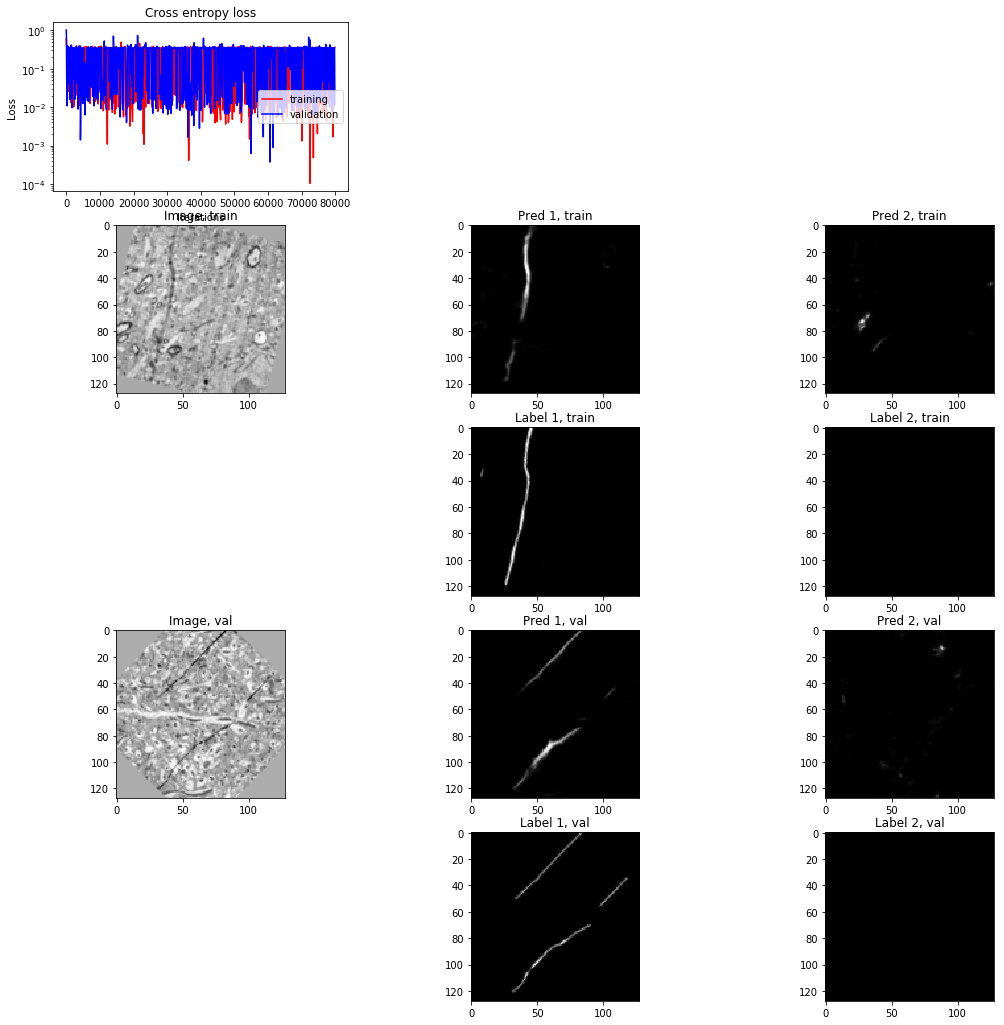

In [50]:
## Train network ##

# params
USECUDA = True
max_iter = 80000
log_every = 100
plot_every = 100
lr = 0.0001

# create net
net = UNet()
if USECUDA:
    net.cuda()
# net = torch.load('basil_defect_unet180701')
    
# create optimizer 
optimizer = optim.Adam(net.parameters(), lr=lr)

# train net
losses_trn = []
losses_val = []
for t in range(max_iter):
    # choose sample
    idx = np.random.randint(0,images_trn.shape[0])
    img = resize(images_trn[idx], mip5_size, preserve_range=True, anti_aliasing=True).astype(np.float32)
    label = resize(labels_trn[idx], mip5_label_size, preserve_range=True, anti_aliasing=True).astype(np.float32)
    # only penalize error for label ids with data
    include = np.sum(label, axis=(1,2)) > 0
    # if negative label, penalize a label id at random
    r = np.random.randint(0, len(label_ids))
    include[r] = True
    mask = np.zeros_like(label)
    mask[include] = np.ones_like(label[include])
    
    # flip
    r = np.random.randint(0,3)
    if r > 1:
        img = np.flip(img,axis=1).copy()
        label = np.flip(label,axis=2).copy()
    if r > 0:
        img = np.flip(img,axis=0).copy()
        label = np.flip(label,axis=1).copy()
    r = np.random.randint(0,1)
    if r == 1:
        img = aug.aug_brightness(img)

    img = np2var(img, cuda=USECUDA)
    label = np2var(label, cuda=USECUDA)
    mask = np2var(mask, cuda=USECUDA)
    
    img, transform = aug.rotate_and_scale(img, size=None)
    label = F.grid_sample(label, transform)
    
    # forward, backward, update
    optimizer.zero_grad()
    pred = net(img)
    label_masked = torch.mul(label, mask)
    pred_masked = torch.mul(pred, mask)
    loss = F.binary_cross_entropy_with_logits(pred_masked, label_masked)
    loss.backward()
    optimizer.step()

    # log stuff
    if t % log_every == 0: 
        # validation info
        idx = np.random.randint(0,images_val.shape[0])
        img_val = resize(images_val[idx], mip5_size, preserve_range=True, anti_aliasing=True).astype(np.float32)
        label_val = resize(labels_val[idx], mip5_label_size, preserve_range=True, anti_aliasing=True).astype(np.float32)
        # only penalize error for label ids with data
        include_val = np.sum(label_val, axis=(1,2)) > 0
        # if negative label, penalize a label id at random
        r = np.random.randint(0, len(label_ids))
        include_val[r] = True
        mask_val = np.zeros_like(label_val)
        mask_val[include_val] = np.ones_like(label_val[include_val])
        
        # flip
        r = np.random.randint(0,3)
        if r > 1:
            img_val = np.flip(img_val,axis=1).copy()
            label_val = np.flip(label_val,axis=2).copy()
        if r > 0:
            img_val = np.flip(img_val,axis=0).copy()
            label_val = np.flip(label_val,axis=1).copy()
        r = np.random.randint(0,1)
        if r == 1:
            img_val = aug.aug_brightness(img_val)
        
        # format
        img_val = np2var(img_val, cuda=USECUDA)
        label_val = np2var(label_val, cuda=USECUDA)
        mask_val = np2var(mask_val, cuda=USECUDA)

        img_val, transform = aug.rotate_and_scale(img_val, size=None)
        label_val = F.grid_sample(label_val, transform)

        # forward
        pred_val = net(img_val)
        label_val_masked = torch.mul(label_val, mask_val)
        pred_val_masked = torch.mul(pred_val, mask_val)
        loss_val = F.binary_cross_entropy_with_logits(pred_val_masked, label_val_masked)

        # store
        losses_trn.append(loss.data[0])
        losses_val.append(loss_val.data[0])
        
    # plot stuff
    if t % plot_every == 0:
        plot(t, log_every, losses_trn, losses_val, 
             img, img_val,
             label.squeeze(0), label_val.squeeze(0),
             pred.squeeze(0), pred_val.squeeze(0))
    
    

In [51]:
PATH = 'basil_defect_unet_mip5{:02d}'.format(save_date)
torch.save(net, PATH)

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type ConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type DownConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type UpConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/pyth